In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind


In [2]:

df = pd.read_csv('leslie_derti_apadb_processed_utr3_all_cuts.csv', sep='\t')


In [3]:
#Apply filters

min_count = 5

df = df.query("leslie_total_count_hek293 >= " + str(min_count) + " and leslie_total_count_testis >= " + str(min_count)).copy().reset_index(drop=True)
df = df.query("leslie_count_hek293 >= 1 and leslie_count_testis >= 1").copy().reset_index(drop=True)
df = df.query("leslie_count_hek293 < leslie_total_count_hek293 and leslie_count_testis < leslie_total_count_testis").copy().reset_index(drop=True)


In [4]:
#Compute total relative isoform abundances

df['leslie_usage_hek293'] = df['leslie_count_hek293'] / df['leslie_total_count_hek293']
df['leslie_usage_testis'] = df['leslie_count_testis'] / df['leslie_total_count_testis']

df['leslie_logodds_hek293'] = np.log(df['leslie_usage_hek293'] / (1. - df['leslie_usage_hek293']))
df['leslie_logodds_testis'] = np.log(df['leslie_usage_testis'] / (1. - df['leslie_usage_testis']))

#Compute relative differences between tissues / cell lines

df['leslie_delta_logodds_testis_hek293'] = df['leslie_logodds_testis'] - df['leslie_logodds_hek293']


In [5]:

df['dse_gt_count'] = df['seq'].str.slice(56, 106).str.count("GTGT")
df['dse_gt_count'] += df['seq'].str.slice(56, 106).str.count("GTCT")
df['dse_gt_count'] += df['seq'].str.slice(56, 106).str.count("TGTT")
df['dse_gt_count'] += df['seq'].str.slice(56, 106).str.count("TTGT")

total_dse_count_df = df.groupby(['gene']).agg({
    "dse_gt_count" : "sum"
}).reset_index().rename(columns={
    "dse_gt_count" : "total_dse_gt_count"
})

if 'total_dse_gt_count' in df.columns :
    df = df.drop(columns=['total_dse_gt_count'])

df = df.join(total_dse_count_df.set_index('gene'), on='gene', how='inner').sort_index()

df['competing_dse_gt_count'] = df['total_dse_gt_count'] - df['dse_gt_count']


In [6]:

df_gt_rich = df.query("dse_gt_count >= 1 and competing_dse_gt_count <= 0")
df_not_gt_rich = df.query("dse_gt_count <= 0")


T-test Statistic = 7.4986644961435
T-test P-value = 8.96920302435304e-14


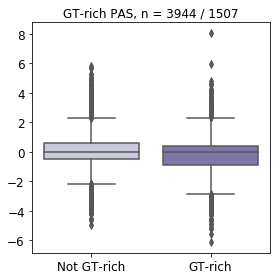

In [7]:

arr_1 = np.array(df_not_gt_rich['leslie_delta_logodds_testis_hek293'].values)
arr_2 = np.array(df_gt_rich['leslie_delta_logodds_testis_hek293'].values)

f = plt.figure(figsize=(4, 4))

sns.boxplot(data=[arr_1, arr_2], palette='Purples')

plt.xticks([0, 1], ['Not GT-rich', 'GT-rich'], fontsize=12)
plt.yticks(fontsize=12)

n_1 = arr_1.shape[0]
n_2 = arr_2.shape[0]

s, p = ttest_ind(arr_1, arr_2, equal_var=False)

print("T-test Statistic = " + str(s))
print("T-test P-value = " + str(p))

plt.title("GT-rich PAS, n = " + str(n_1) + " / " + str(n_2), fontsize=12)

plt.tight_layout()

plt.savefig("apa_leslie_testis_gt_rich_boxplot.png", dpi=300, transparent=True)
plt.savefig("apa_leslie_testis_gt_rich_boxplot.eps")

plt.show()


T-test Statistic = -4.24359526539767
T-test P-value = 2.282225376309109e-05


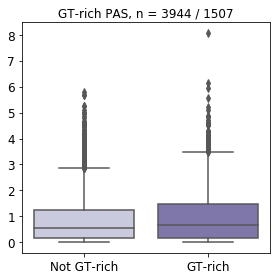

In [8]:

arr_1 = np.abs(np.array(df_not_gt_rich['leslie_delta_logodds_testis_hek293'].values))
arr_2 = np.abs(np.array(df_gt_rich['leslie_delta_logodds_testis_hek293'].values))

f = plt.figure(figsize=(4, 4))

sns.boxplot(data=[arr_1, arr_2], palette='Purples')

plt.xticks([0, 1], ['Not GT-rich', 'GT-rich'], fontsize=12)
plt.yticks(fontsize=12)

n_1 = arr_1.shape[0]
n_2 = arr_2.shape[0]

s, p = ttest_ind(arr_1, arr_2, equal_var=False)

print("T-test Statistic = " + str(s))
print("T-test P-value = " + str(p))

plt.title("GT-rich PAS, n = " + str(n_1) + " / " + str(n_2), fontsize=12)

plt.tight_layout()

plt.savefig("apa_leslie_testis_gt_rich_boxplot_abs.png", dpi=300, transparent=True)
plt.savefig("apa_leslie_testis_gt_rich_boxplot_abs.eps")

plt.show()
